In [1]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym
import quantstats as qs
# import gym_anytrading

import sys
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading")
import importlib
%load_ext autoreload
%autoreload 2
from envs import MyForexEnv, Actions
# sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/")
# from datasets import FOREX_EURUSD_RENKO
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback
import torch

In [2]:
name = 'FOREX_EURUSD_RENKO'
# base_dir = os.path.dirname(os.path.abspath(__file__))
path = "C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading/datasets/data/renko_full_data_81.csv"
# path = os.path.join(base_dir, '.csv')
FOREX_EURUSD_RENKO = pd.read_csv(path, parse_dates=True, index_col='datetime')

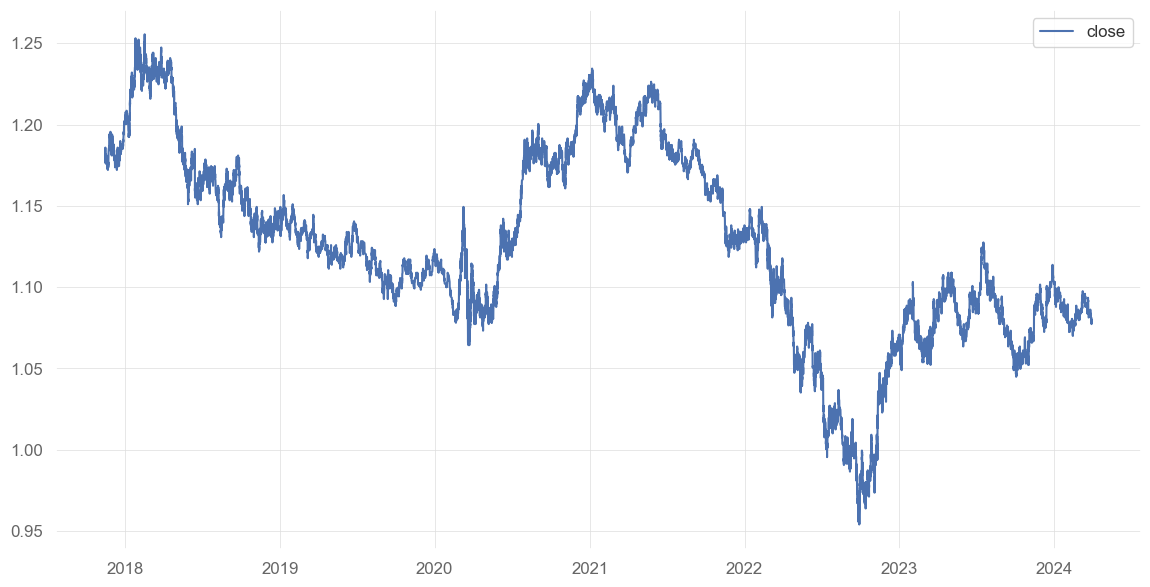

In [4]:
# plot the close price over time
plt.figure(figsize=(14, 7))
plt.plot(FOREX_EURUSD_RENKO.close, label='close')
plt.legend()
plt.show()


In [6]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()

In [7]:
env_train = MyForexEnv(
    df=FOREX_EURUSD_RENKO,
    window_size=10,
    frame_bound=(10, int(len(FOREX_EURUSD_RENKO)*.8)),
    trade_fee=0.0001,
    spread=0.0001,
    spread_bool=True,
    unit_side='right',
    sma_length=4,
    smoothing_sma=4
)
print(int(len(FOREX_EURUSD_RENKO)*.8))

25923


In [8]:
seed_ppo = 42  # random seed
obs_ppo, info_ppo = env_train.reset(seed=seed_ppo)
torch.manual_seed(seed_ppo)
random.seed(seed_ppo)
np.random.seed(seed_ppo)

vec_env_ppo = None

total_learning_timesteps_ppo = 5000 * 1000 # 5000
policy_dict_ppo = PPO.policy_aliases
policy_ppo = policy_dict_ppo.get('MlpPolicy')
if policy_ppo is None:
    policy_ppo = policy_dict_ppo.get('MlpLstmPolicy')

model_ppo = PPO(policy_ppo, env_train, verbose=0)

print(f'model {type(model_ppo)}')
print(f'policy {type(model_ppo.policy)}')

# custom callback for 'progress_bar'
model_ppo.learn(total_timesteps=total_learning_timesteps_ppo, callback=ProgressBarCallback(100))

env_train.close()

model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 5001200it [3:38:27, 381.56it/s]                               


In [9]:
env_test = MyForexEnv(
    df=FOREX_EURUSD_RENKO,
    window_size=10,
    frame_bound=(int(len(FOREX_EURUSD_RENKO)*.8), int(len(FOREX_EURUSD_RENKO)*.99)),
    trade_fee=0.0001,
    spread=0.0001,
    spread_bool=True,
    unit_side='right',
    sma_length=4,
    smoothing_sma=4
)

# Random Actions

In [11]:
done = False
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
observation, info_ppo = env_test.reset(seed=seed_ppo)

while not done:
    action_ppo, _states = model_ppo.predict(obs_ppo)
    action_stats[Actions(action_ppo)] += 1
    obs_ppo, reward_ppo, terminated, truncated, info_ppo = env_test.step(action_ppo)
    done = terminated or truncated

    if done:
        break

env_test.close()

print("action_stats:", action_stats)
print("info:", info_ppo)

action_stats: {<Actions.Sell: 0>: 0, <Actions.Buy: 1>: 6155}
info: {'total_reward': -17.199350357055554, 'total_profit': 1.0388749797910983, 'position': <Positions.Long: 1>}


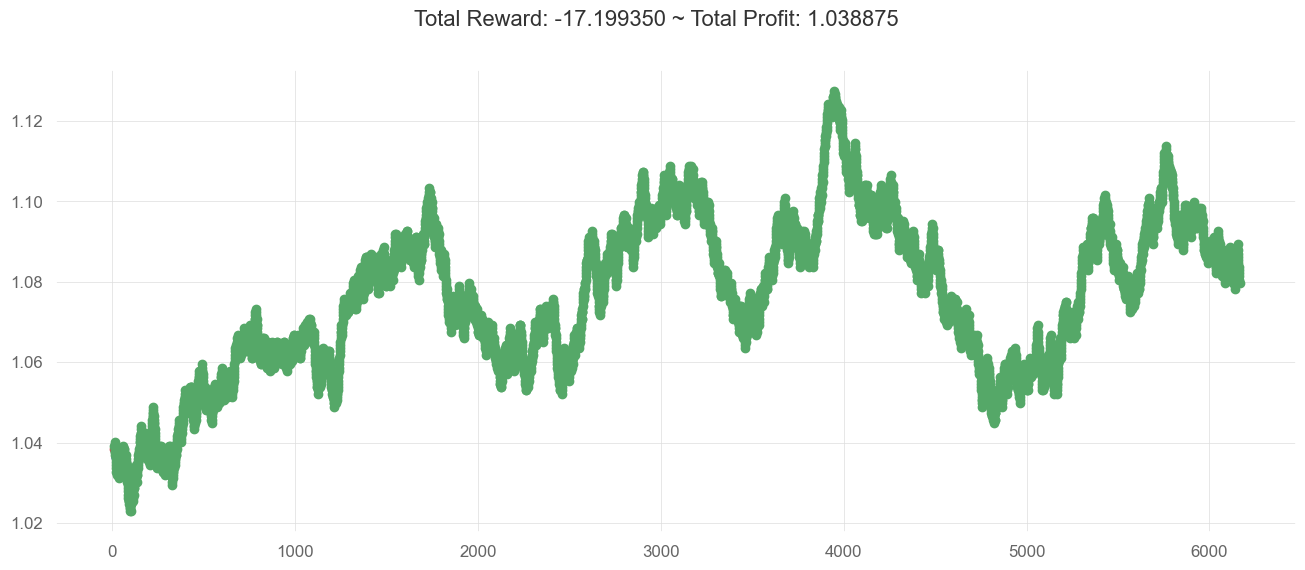

In [12]:
plt.figure(figsize=(16, 6))
env_test.unwrapped.render_all()
plt.show()

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes 

                           Strategy
-------------------------  ----------
Start Period               2022-11-17
End Period                 2024-02-02
Risk-Free Rate             0.0%
Time in Market             1.0%

Cumulative Return          3.89%
CAGR﹪                     2.2%

Sharpe                     0.2
Prob. Sharpe Ratio         97.72%
Smart Sharpe               -
Sortino                    -
Smart Sortino              -
Sortino/√2                 -
Smart Sortino/√2           -
Omega                      -

Max Drawdown               %
Longest DD Days            -
Volatility (ann.)          0.79%
Calmar                     -
Skew                       78.45
Kurtosis                   6154.0

Expected Daily %           0.0%
Expected Monthly %         0.24%
Expected Yearly %          1.28%
Kelly Criterion            -
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.08%
Expected Shortfall (cVaR)  -0.08%

Max Consecutive Wins       1
Max Consecutive Losses     0
Gain/P

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


None

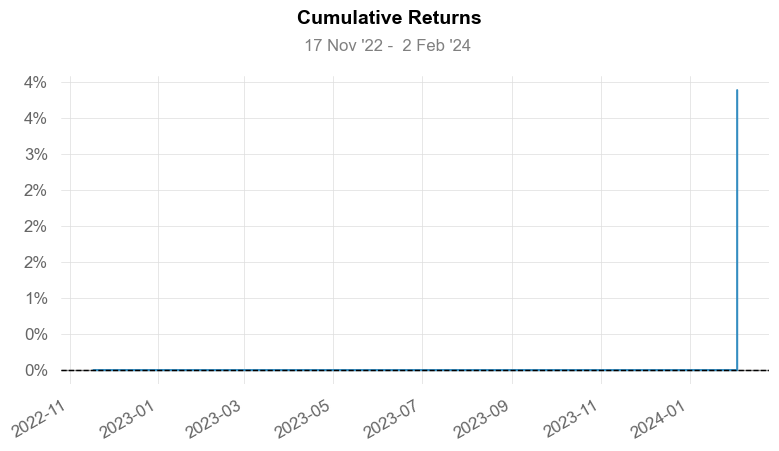

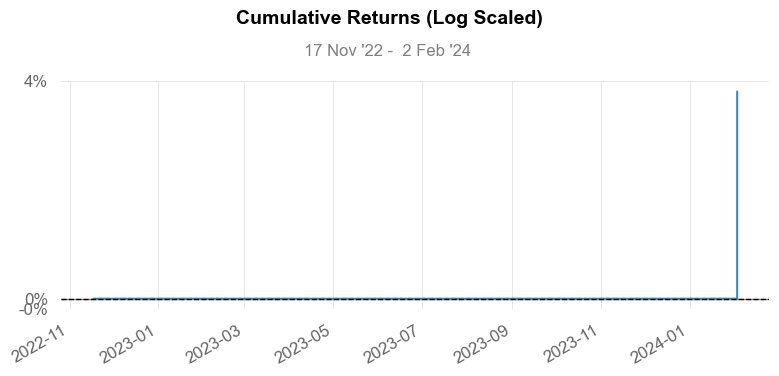

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\quantstats\_plotting\wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\quantstats\_plotting\wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


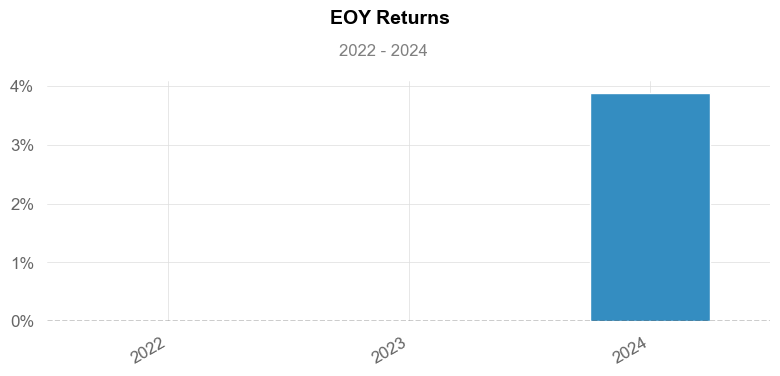

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\quantstats\_plotting\core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


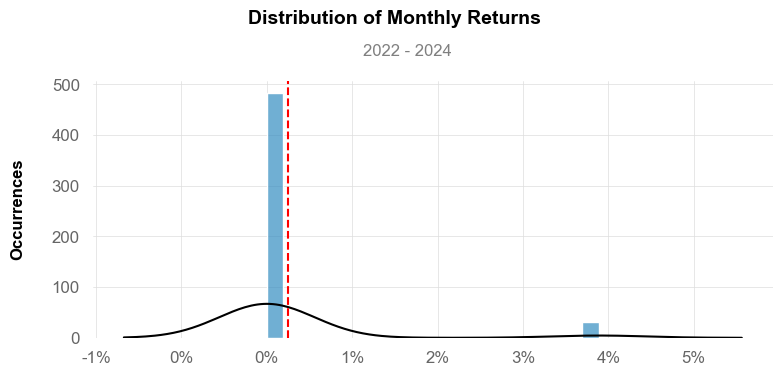

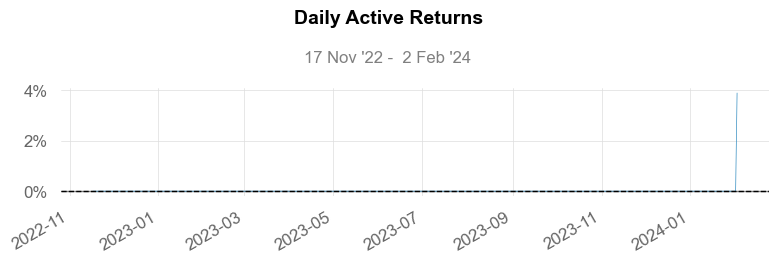

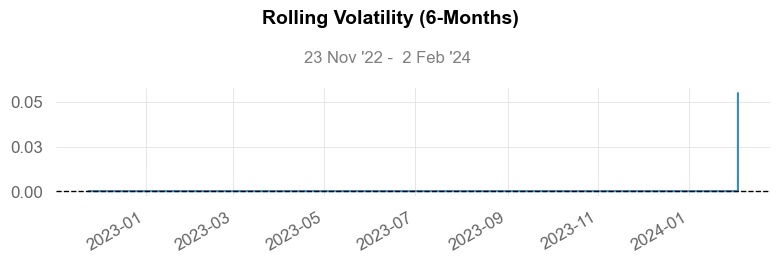

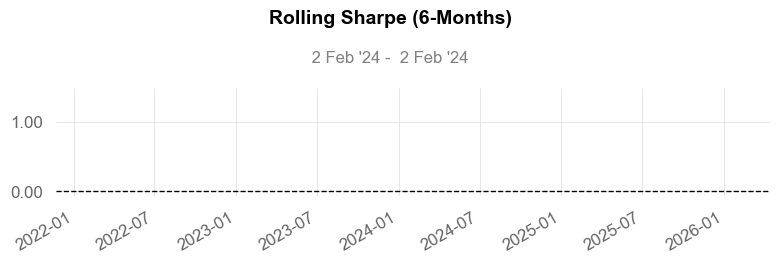

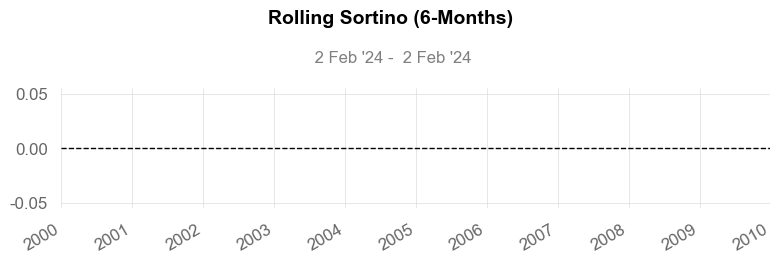

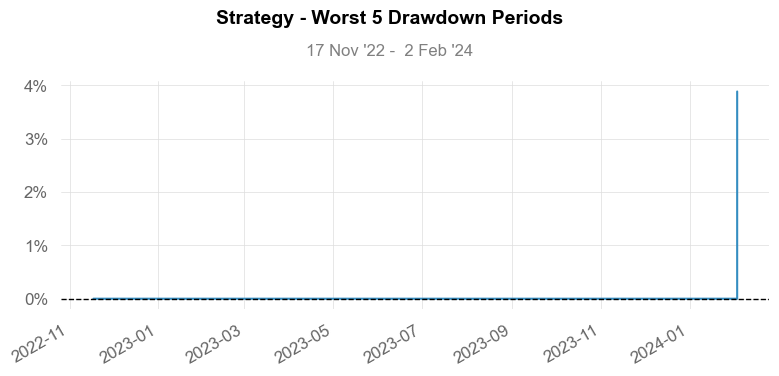

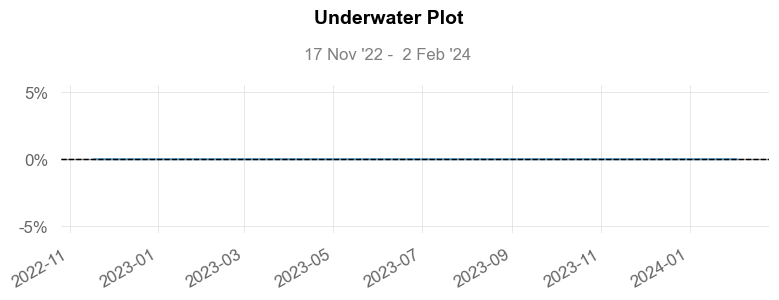

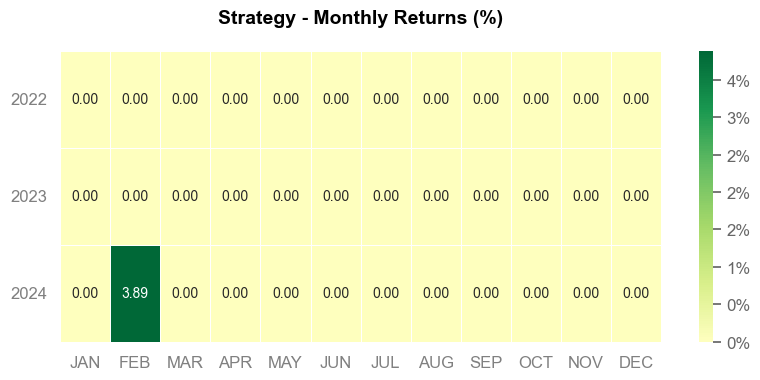

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
c:\Users\WilliamFetzner\AppData\Local\Programs\Python

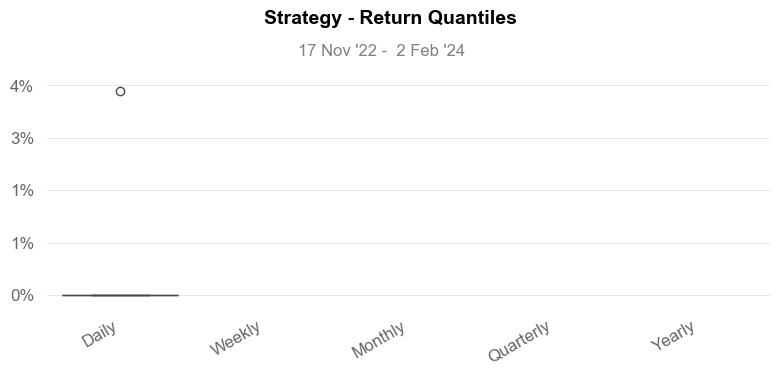

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes 

In [13]:
qs.extend_pandas()
window_size = 10
start_index = int(len(FOREX_EURUSD_RENKO)*.8)
end_index = int(len(FOREX_EURUSD_RENKO)*.99)

net_worth = pd.Series(env_test.unwrapped.history['total_profit'], index=FOREX_EURUSD_RENKO.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats_ppo_4_3.html')